<a href="https://colab.research.google.com/github/haebarassi/kaggleStudy/blob/master/CarInsurancePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
# 본인이 참가한 모든 대회 보기 
!kaggle competitions list
!ls -al
!ls -al ~/
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!ls -al ~/.kaggle/
!kaggle competitions list


Saving kaggle.json to kaggle (1).json
ref                                                       deadline             category            reward  teamCount  userHasEntered  
--------------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
mpetitions/contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         38           False  
mpetitions/gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        136           False  
mpetitions/store-sales-time-series-forecasting            2030-06-30 23:59:00  Getting Started  Knowledge       1041           False  
mpetitions/tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        166           False  
mpetitions/digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2120           False  
mpetitions/titani

In [ ]:
!kaggle competitions download -c porto-seguro-safe-driver-prediction
!ls

 97% 74.0M/76.5M [00:01<00:00, 81.7MB/s]
100% 76.5M/76.5M [00:01<00:00, 58.8MB/s]
'kaggle (1).json'   porto-seguro-safe-driver-prediction.zip   titanic.zip
 kaggle.json	    sample_data


In [ ]:
!unzip porto-seguro-safe-driver-prediction.zip

Archive:  porto-seguro-safe-driver-prediction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer  # 원래 예시에 있던 Imputer는 사라지고 이걸로 대체되었음
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [ ]:
train.tail()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
595207,1488013,0,3,1,10,0,0,0,0,0,...,4,1,9,6,0,1,1,0,1,1
595208,1488016,0,5,1,3,0,0,0,0,0,...,4,1,3,8,1,0,1,0,1,1
595209,1488017,0,1,1,10,0,0,1,0,0,...,3,2,2,6,0,0,1,0,0,0
595210,1488021,0,5,2,3,1,0,0,0,1,...,4,1,4,2,0,1,1,1,0,0
595211,1488027,0,0,1,8,0,0,1,0,0,...,4,4,3,8,0,1,0,0,0,0


In [ ]:
train.shape

(595212, 59)

중복되는 컬럼이 있다면 삭제해준다

In [ ]:
train.drop_duplicates()
train.shape

(595212, 59)

- 없음

test 데이터셋에 빠진 컬럼이 있는지 확인한다.

In [ ]:
test.shape

(892816, 58)

- target으로 쓰이는 변수만 빼고 모두 있음을 알 수 있다.

# categorial variables를 dummy variables로 만들기

- binary의 경우 dummification 필요 없음

In [ ]:
# 변수의 데이터타입을 확인해보자.
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

- null이 없다고는 나오지만 -1로 포함되어 있으니 나중에 살펴보자!

# 어떤 모양의 컬럼들이 있는지 살펴보기 (Metadata)

- role: input(분석에 사용할 정보 컬럼들)과 ID, target을 구분해준다.
- level: nominal, interval, ordinal, binary
- keep: True or False
- dtype: int, float, str

In [ ]:
data = []
for f in train.columns:
  # target과 id를 나타내는 컬럼 구분해주기
  if f == 'target':
    role = 'target'
  elif f == 'id':
    role = 'id'
  else:
    role = 'input'

  # 데이터 내용이 어떤 형식으로 구성되어있는지 구분해주기
  if 'bin' in f or f == 'target':
    level = 'binary'
  # id 와 cat은 명목변수이다.
  elif 'cat' in f or f =='id':
    level = 'nominal'
  # float 실수형 데이터는 등간 변수일 것이다
  elif train[f].dtype == float:
    level = 'interval'
  # int 정수형 데이터는 서열 변수일 것이다
  elif train[f].dtype == int:
    level = 'ordinal'
  
  # id 제외하고 모두 keep을 True로 초기화해주기
  # : id는 분석에 쓰이지 않을 거니까 나중에 쉽게 빼기 위해서 keep = False로 처리해준다.
  keep = True
  if f == 'id':
    keep = False

  # 데이터타입 정보  
  dtype = train[f].dtype
  
  # 한 사람의 정보마다 Dictionary 만들어서 data array에 넣어준다.
  f_dict = {
      'varname': f,
      'role': role,
      'level': level,
      'keep': keep,
      'dtype': dtype
  }
  data.append(f_dict)

In [ ]:
data

[{'dtype': dtype('int64'),
  'keep': False,
  'level': 'nominal',
  'role': 'id',
  'varname': 'id'},
 {'dtype': dtype('int64'),
  'keep': True,
  'level': 'binary',
  'role': 'target',
  'varname': 'target'},
 {'dtype': dtype('int64'),
  'keep': True,
  'level': 'ordinal',
  'role': 'input',
  'varname': 'ps_ind_01'},
 {'dtype': dtype('int64'),
  'keep': True,
  'level': 'nominal',
  'role': 'input',
  'varname': 'ps_ind_02_cat'},
 {'dtype': dtype('int64'),
  'keep': True,
  'level': 'ordinal',
  'role': 'input',
  'varname': 'ps_ind_03'},
 {'dtype': dtype('int64'),
  'keep': True,
  'level': 'nominal',
  'role': 'input',
  'varname': 'ps_ind_04_cat'},
 {'dtype': dtype('int64'),
  'keep': True,
  'level': 'nominal',
  'role': 'input',
  'varname': 'ps_ind_05_cat'},
 {'dtype': dtype('int64'),
  'keep': True,
  'level': 'binary',
  'role': 'input',
  'varname': 'ps_ind_06_bin'},
 {'dtype': dtype('int64'),
  'keep': True,
  'level': 'binary',
  'role': 'input',
  'varname': 'ps_ind_07_bi

- 이렇게 딕셔너리가 담긴 배열로 저장된 data를 DataFrame으로 보기 좋게 만들어준다
  - varname은 분석에 사용되지는 않으므로 index로 넣는다. 

In [ ]:
meta = pd.DataFrame(data, columns=['varname','role','level','keep','dtype'])
meta.set_index('varname',inplace=True)

In [ ]:
meta

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


In [ ]:
meta[(meta.level == 'nominal') & (meta.keep)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

각 role별 level이 몇 종류이며 각 level의 종류별로 몇 개의 컬럼이 속하는지 알아보자.

In [ ]:
pd.DataFrame({'count':meta.groupby(['role','level'])['role'].size()}).reset_index()

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


## datatype 별로 각 변수들이 어떤 특성 가지고 있는지 살펴보기

- dataframe의 describe를 이용해 평균, 표준편차,...등의 수치 분석내역을 살펴보자
- categorical variable의 경우 숫자적으로 살펴볼 필요는 없으니 이건 지금은 손대지 말고 뒤에서 시각화 하자

### interval variables 등간변수

In [ ]:
# id는 빼고, level이 interval로 구분되어있는 데이터들만 분석해보자
v = meta[(meta.level == 'interval') & (meta.keep)].index
train[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


reg라는 변수를 살펴보면,
- ps_reg_02만 min값이 -1로, missing data를 포함한다.
- 수치의 범위(min~max)는 변수마다 다르다. -> 나중에 StandardScaler로 스케일링 적용해서 맞춰주자


car 변수를 살펴보면,
- ps_car_12와 ps_car_15만 결측값이 있다.
- 이 변수 또한 범위가 각각 달라서 scaling이 필요해보인다. 

calc 변수를 살펴보면, 
- 결측값이 없고, 
- 가장 큰 값이 0.9인 어떤 비율?인걸로 보인다.. 모두 0~0.9의 범위를 갖ㄴ느다.

등간 변수들의 범위가 비교적 작은걸로 보인다. 이런 점에서 이미 log와 같은 어떤 변환을 이미 한 데이터일지도 모르겠다. 

### Ordinal variables 서열척도

In [ ]:
v = meta[(meta.level == 'ordinal')& (meta.keep)].index
train[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


- 결측값 있는건 ps_car_11 뿐이네
- 범위가 달라서 scaling 해야겠다. 

### Binary variables

In [ ]:
v = meta[(meta.level == 'binary')&(meta.keep)].index
train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- 모든 값의 평균을 낸 것이 0.03645로 3.645퍼센트만이 1이다. 매우 불균형한 데이터!
- 평균이 대부분 0에 가까운 걸로 봐서 대부분 값이 0이라는 걸 알 수 있다.
 - 그럼 binary 1을 가지는 사람들의 공통 특징이 있지 않을까 ??
  - 원래 보통 imbalanced한 값은 거의 쓰이지 못하는데, 5%만 어쩌구
    - xgbooster에서는 쓸 수 있다. 그 내부에서 알아서 어떻게 어떻게 처리해준다고 한다

### imbalanced한 클래스들 handling하기

- imbalanced한 값은 모델을 매우 높은 정확도가 나오도록 해줄 수는 있지만 실질적으로 예측에 도움을 주지 못한다. 
- ** 예시 다시 보기 예를들어, 생존 비율을 예측하고 싶은데, 5명이 죽었다는 것만으로 99%의 정확도가 나올 수 있다?
- 이 문제를 어떻게 해결할까?
  1. target = 1 인 항목들 oversampling
  2. target = 0 인 항목들 undersampling

#### Oversampling과 Undersampling

https://casa-de-feel.tistory.com/15

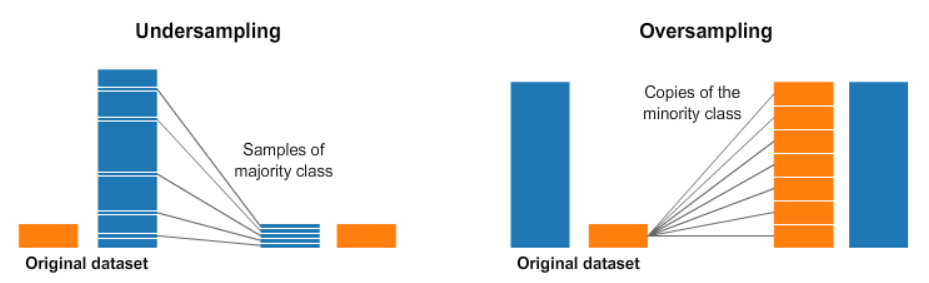

In [ ]:
desired_apriori = 0.1

# target value가 0인 것과 1인 것 나누기
idx_0 = train[train.target == 0].index
idx_1 = train[train.target == 1].index

# target value 각각의 개수
nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])

# 
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling:{}'.format(undersampled_nb_0))

# 랜덤하게 target=0인 데이터를 골라서 desired apriori를 얻는다
undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

# Construct list with remaining indices
idx_list = list(undersampled_idx) + list(idx_1)

# Return undersample data frame
train = train.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undersampling:195246
